In [1]:
import collections
import os

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib nbagg


# Directory with unzipped copy of GovTrack's US congress data
# https://data.world/govtrack/us-congress-legislators
DATA_DIR = os.path.join(os.getcwd(), 'govtrack-us-congress-legislators')

In [2]:
df_legislators = pd.concat([
    pd.read_csv(os.path.join(DATA_DIR, 'legislators-historical.csv')),
    pd.read_csv(os.path.join(DATA_DIR, 'legislators-current.csv')),
], axis=0, sort=False)

df_legislators.birthday_bio = pd.to_datetime(df_legislators.birthday_bio)

In [3]:
df_terms = pd.concat([
    pd.read_csv(os.path.join(DATA_DIR, 'legislators-historical-terms.csv'), low_memory=False),
    pd.read_csv(os.path.join(DATA_DIR, 'legislators-current-terms.csv'), low_memory=False),
], axis=0, sort=False).set_index('bioguide')

df_terms.start = pd.to_datetime(df_terms.start)
df_terms.end = pd.to_datetime(df_terms.end)

In [4]:
df_full = pd.merge(
    df_terms, df_legislators,
    how='left', left_on='bioguide', right_on='bioguide_id'
)

is_missing_dt = pd.concat([
    df_full.birthday_bio.isnull(),
    df_full.start.isnull(),
    df_full.end.isnull()
], axis=1).any(axis=1)

# There are some mystery-terms that link to people born well after they started...
is_bad_age = ((df_full.start - df_full.birthday_bio).dt.days // 365) < 25

df_full = df_full[~is_missing_dt & ~is_bad_age]

In [5]:
date_age_list = []
for _, bio_row in df_full.iterrows():
    date_span = pd.date_range(bio_row.start, bio_row.end + pd.DateOffset(n=-7), closed='left', freq='365D')
    for date in date_span:
        age = (date - bio_row.birthday_bio).days // 365
        date_age_list.append((date, age, bio_row.type))

            
#if date < pd.datetime.now():

df_ages = pd.DataFrame(
    date_age_list,
    columns=['date', 'age', 'type']
)

df_ages['year'] = df_ages.date.dt.year

In [6]:
df_full.start.max()

Timestamp('2017-01-03 00:00:00')

In [7]:
median_age = (
    df_ages.
    groupby(['type', 'year'])['age'].
    quantile([0.25, 0.5, 0.75]).
    reset_index().
    rename(columns={'level_2': 'qtile'})
)

count_age = (
    df_ages.groupby(['type', 'year', 'age'])['date'].
    count().
    reset_index().
    rename(columns={'date':'num_ages'})
)

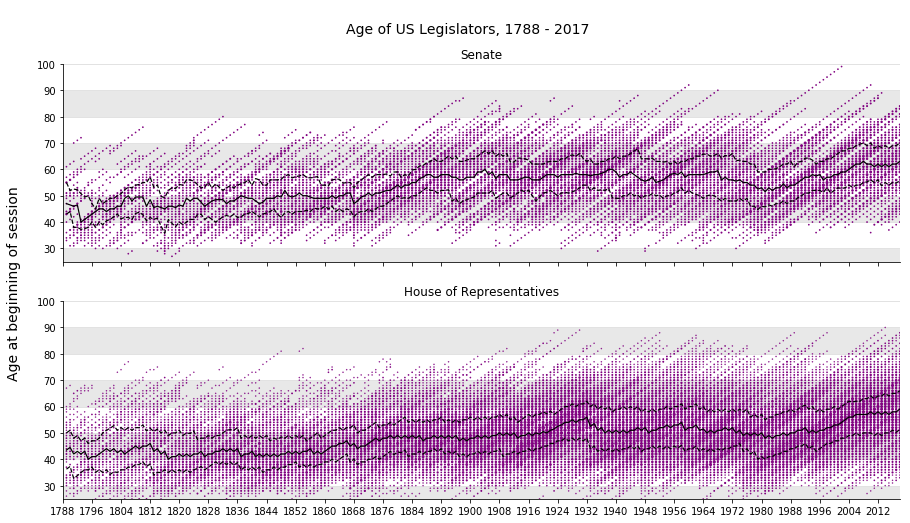

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8), sharex=True)

scatter_kwargs = {
    'alpha': 1.0,
    'marker': 'o',
    'linewidths': None,
    'edgecolors': None,
    'c': 'purple',
    'zorder': 2
}

scatter_size_mult = {
    'sen': 0.22 * pd.np.sqrt(5),
    'rep': 0.22,
}

line_args = {
    0.25: ['--k'],
    0.5: ['-k'],
    0.75: ['--k']
}

line_kwargs = {
    'linewidth': 1.2,
    'zorder': 3
}

cong_types = {
    'sen': 'Senate',
    'rep': 'House of Representatives'
}

year_limits = [1788, 2018]
age_limits = [25, 100]

bg_color = 'lightgrey'
bg_kwargs = {
    'xmin': 0,
    'xmax': 1.0,
    'zorder': 1,
    'alpha': 0.5,
}

age_band_colors = {
    (dec, dec + 10): bg_color
    for dec in range(20, 100+1, 10)
    if dec % 20 == 0
}

for ax, (cong_type, full_cong_type) in zip(axes, cong_types.items()):

    ax.set_title(full_cong_type)
    _df_age_count = count_age[count_age.type == cong_type]
    _df_age_med = median_age.loc[median_age.type == cong_type]

    ax.set_xticks(range(*year_limits, 8))
    ax.set_xlim(*year_limits)
    ax.set_ylim(*age_limits)
    ax.set_ylabel('.', color=(0, 0, 0, 0))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

    for barlims, color in age_band_colors.items():
        ax.axhspan(*barlims, color=color, **bg_kwargs)

    ax.scatter(
        _df_age_count.year,
        _df_age_count.age,
        s=scatter_size_mult[cong_type]*_df_age_count.num_ages,
        **scatter_kwargs
    )

    for q, _df in _df_age_med.groupby('qtile'):
        ax.plot(_df.year, _df.age, *line_args[q], **line_kwargs)

fig.suptitle(".", color=(0, 0, 0, 0))
fig.text(
    0.5, 0.94, 'Age of US Legislators, 1788 - 2017',
    va='center', ha='center', rotation='horizontal',
    fontsize=14
)

fig.text(
    0.08, 0.5, 'Age at beginning of session',
    va='center', ha='center', rotation='vertical',
    fontsize=14
)

fig.savefig(
    'congressional_ages_over_time.png',
    transparent=False,
    frameon=False,
    dpi=350
)